In [25]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

In [26]:
net_heat = ContTempNetwork.load('fig3_growing_network300')

# Derivative

In [27]:
lamdas_growing = np.logspace(-4,0,200)

In [28]:
multi_res_heat = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_growing]


In [29]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [44]:
lamdas_vNS = np.logspace(-3,1,200)

vNS_heat_end = []
spectral_vNS_heat_end = []
spectral_vNS_heat_end_old = []
for i, lamda in enumerate(lamdas_vNS):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end.append(S[list(S.keys())[0]][0])

    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/spectral_vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        spectral_vNS_heat_end.append(S[list(S.keys())[0]][0])

In [45]:
S1 = vNS_heat_end
S2 = spectral_vNS_heat_end

between_lamdas_vNS = np.linspace(-3,1,200)

Q1 = derivative(S1, between_lamdas_vNS)
Q2 = derivative(S2, between_lamdas_vNS)

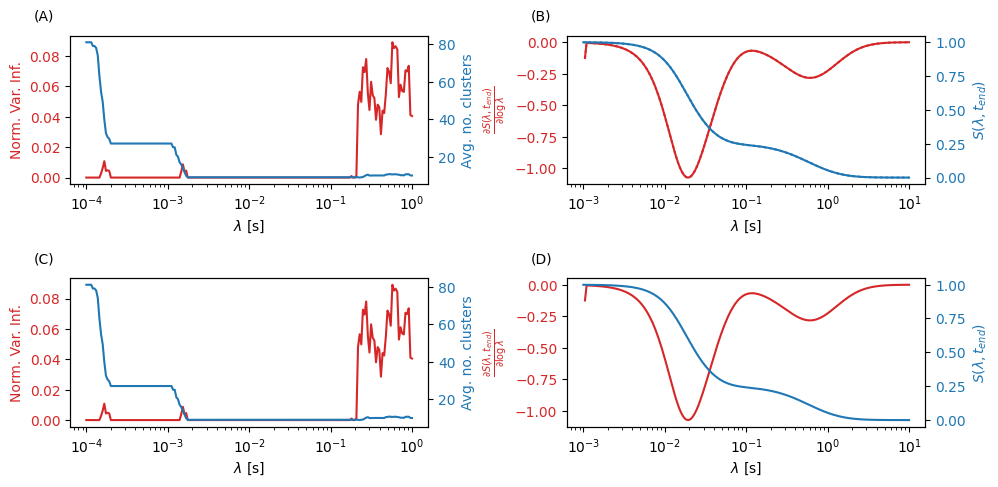

In [48]:
fig, axs = plt.subplots(2,2, sharex=False, figsize=(10, 5))

####### Third Plot
color = 'tab:red'
axs[0,0].plot(lamdas_growing, NVI_forw_heat, color=color, label='static norm NVI')

axs[0,0].set_xscale('log')
axs[0,0].set_xlabel(r'$\lambda$ [s]')
axs[0,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[0,0].tick_params(axis='y', labelcolor=color)
axs[0,0].text(-0.1,1.1, '(A)', transform=axs[0,0].transAxes)

ax1 = axs[0,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing, avg_nclusters_forw_heat, color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

####### Second Plot

color = 'tab:red'
axs[0,1].plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')
axs[0,1].plot(lamdas_vNS[1:], Q2, ':', color=color, label='dvNSdt')

axs[0,1].set_xscale('log')
axs[0,1].set_xlabel(r'$\lambda$ [s]')

axs[0,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0,1].tick_params(axis='y', labelcolor=color)
axs[0,1].text(-0.1,1.1, '(B)', transform=axs[0,1].transAxes)

ax2 = axs[0,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(lamdas_vNS, vNS_heat_end, color=color, label='vNS')
ax2.plot(lamdas_vNS, spectral_vNS_heat_end, ':', color=color, label='vNS')

ax2.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)



####### Third Plot
color = 'tab:red'
axs[1,0].plot(lamdas_growing, NVI_forw_heat, color=color, label='static norm NVI')

axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$\lambda$ [s]')
axs[1,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[1,0].tick_params(axis='y', labelcolor=color)
axs[1,0].text(-0.1,1.1, '(C)', transform=axs[1,0].transAxes)

ax3 = axs[1,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_growing, avg_nclusters_forw_heat, color=color, label='edge-centric')

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axs[1,1].plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')

axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$\lambda$ [s]')

axs[1,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1,1].tick_params(axis='y', labelcolor=color)
axs[1,1].text(-0.1,1.1, '(D)', transform=axs[1,1].transAxes)

ax4 = axs[1,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_heat_end, color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Last Plot

In [37]:
selected_lamdas = np.logspace(-3,1,10)
sample_times = list(np.arange(0, len(net_heat.times), 10))

In [42]:
vNS_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/vNS_selected/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        vNS_selected.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

spectral_vNS_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/spectral_vNS_selected/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        spectral_vNS_selected.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])


/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotx/_optimize.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  s[mask] = numpy.linalg.lstsq(AtA[mask][:, mask], Atb[mask], rcond=None)[0]
/tmp/ipykernel_284759/371346436.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f

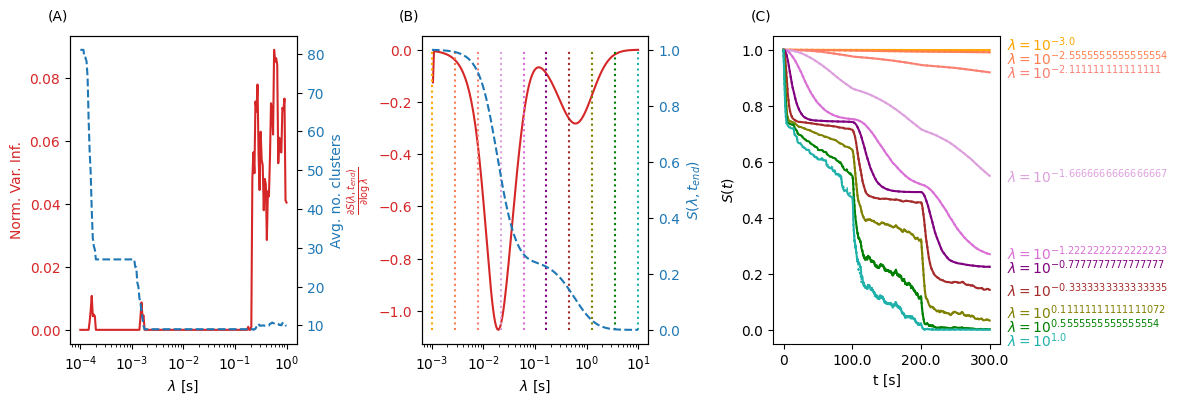

In [43]:
# Create a 2x3 grid of subplots with specific figure size
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.55)


####### Third Plot
color = 'tab:red'
axsc = plt.subplot(gs[0,0])
axsc.plot(lamdas_growing, NVI_forw_heat, color=color)

axsc.set_xscale('log')
axsc.set_xlabel(r'$\lambda$ [s]')
axsc.set_ylabel('Norm. Var. Inf.', color=color)
axsc.tick_params(axis='y', labelcolor=color)
axsc.text(-0.1,1.05, '(A)', transform=axsc.transAxes)

ax3 = axsc.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_growing, avg_nclusters_forw_heat, '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axsd = plt.subplot(gs[0,1])
axsd.plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')

axsd.set_xscale('log')
axsd.set_xlabel(r'$\lambda$ [s]')

axsd.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axsd.tick_params(axis='y', labelcolor=color)
axsd.text(-0.1,1.05, '(B)', transform=axsd.transAxes)

min_ds7dt = np.min(Q1)
max_ds7dt = np.max(Q1)
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
axsd.vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt],
            ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt],
            colors= list_colors, linestyles='dotted')

ax4 = axsd.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_heat_end, '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)


#Plot 5
list_annotate_y = []
for i, lamda in enumerate(selected_lamdas):
    list_annotate_y.append(np.mean(vNS_selected[i]))

shift_annotate_y = [0.01, 0.03, 0.02, -0.05, -0.4, -0.35, -0.05, -0.05, -0.06]

axse = plt.subplot(gs[0,2])
for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-3,1,10)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    axse.plot(net_heat.times[sample_times], vNS_selected[i], color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)
    axse.plot(net_heat.times[sample_times], spectral_vNS_selected[i], ':', color = list_colors[i])
    axse.set_xlabel('t [s]')
    #axse.annotate(text = r'$\lambda = e^{%s}$' % exponent, xy=[100, list_annotate_y[i]], xytext=[105, list_annotate_y[i]+shift_annotate_y[1]-0.05], color='magenta')
axse.text(-0.1,1.05, '(C)', transform=axse.transAxes)
axse.set_ylabel(r'$S(t)$')
matplotx.line_labels()
#axse.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1))


deltat1 = 300 / 3
plt.xticks([0, deltat1, 2*deltat1, 3*deltat1,],[0, str(deltat1), str(2*deltat1), str(3*deltat1)])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/plots250/figNetSci_rev.eps', format='eps', dpi=300)
plt.show()

# Entropy Rate

In [20]:
spectrum_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/spectrum_selected/spectrum{lamda:.11f}', 'rb') as f:
        eigs = pickle.load(f)
        spectrum_selected.append(eigs['spectrum'][f'{lamda:.11f}'])

In [21]:
spectrum_selected[-6][-1500]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 3.41172697e-05, 8.66592121e-05, 1.09336947e-04,
       1.52006450e-04, 1.80807270e-04, 1.92937143e-04, 2.57515225e-04,
       2.81986117e-04, 3.38419688e-04, 4.06118819e-04, 4.17166281e-04,
       4.53348778e-04, 5.06043789e-04, 5.82732644e-04, 7.78846846e-04,
       9.68563517e-04, 9.89021679e-04, 1.13582823e-03, 1.24375012e-03,
       1.29667836e-03, 1.45747859e-03, 1.51380166e-03, 1.53565178e-03,
       1.64232201e-03, 1.67273228e-03, 1.81150387e-03, 1.85120784e-03,
       1.90456966e-03, 2.15964386e-03, 2.93929694e-02, 3.13307564e-02,
      

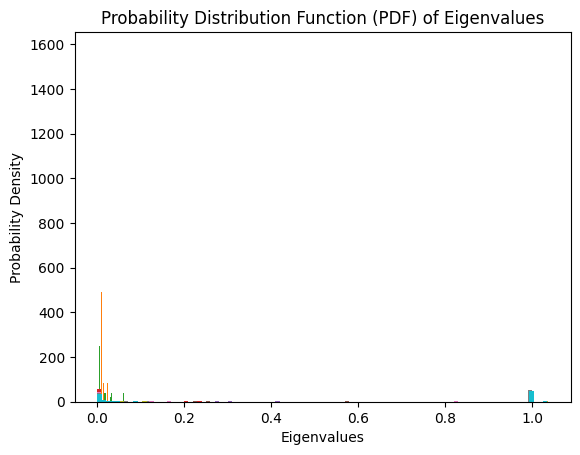

In [22]:
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
for i, spectrum in enumerate(spectrum_selected):
    plt.hist(spectrum[-1], bins=100, density=True)

plt.title('Probability Distribution Function (PDF) of Eigenvalues')
plt.xlabel('Eigenvalues')
plt.ylabel('Probability Density')
plt.show()